# GOOGLE OR TOOLS

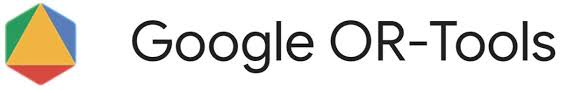

[![Launch on Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/boiro9/curso-OptPy/HEAD?labpath=03-GoogleORTools.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/boiro9/curso-OptPy/blob/HEAD/03-GoogleORTools.ipynb)

```{admonition} 🌐 Características
:class: tip

- Web referencia: https://developers.google.com/optimization?hl=es
- Proporciona una interfaz general para problemas de programación lineal
- Permite conectarse con gran variedad de solvers: Gurobi, CPLEX, CLP, CBC, CPLEX, SCIP, GLPK,...
- Han desarrollado un solver lineal propio (no admite variables enteras): GLOP
- Tiene implementado **algoritmos específicos** para la resolución de **problemas de flujo en redes**.
```

# Resolviendo mi primer PLE con GOOGLEOR
\begin{align*}
\textrm{Maximizar}\ \ \     &  3x+y\\
\textrm{sujeto a}\ \ \      & x+y\leq 2\\
                            & 0\leq x \leq 1\\
                 \ \ \       & 0\leq y \leq 2\\                     
\end{align*}

### Importamos los paquetes necesarios

In [6]:
from ortools.linear_solver import pywraplp

### Establecemos la interfaz del solver con la que queremos trabajar

In [7]:
solver = pywraplp.Solver.CreateSolver("GLOP")

### Creamos las variables

In [8]:
x = solver.NumVar(0, 1, 'x')
y = solver.NumVar(0, 2, 'y')

print('Number of variables =', solver.NumVariables())

Number of variables = 2


### Añadimos la restricción: $x+y\leq 2$

In [9]:
ct = solver.Constraint(0, 2, 'ct')
ct.SetCoefficient(x, 1)
ct.SetCoefficient(y, 1)

print('Number of constraints =', solver.NumConstraints())

Number of constraints = 1


### Definimos la función objetivo: $3x+y$

In [10]:
# Create the objective function, 3 * x + y.
objective = solver.Objective()
objective.SetCoefficient(x, 3)
objective.SetCoefficient(y, 1)
objective.SetMaximization()

### Resolvemos e imprimimos la solución

In [11]:
print(f'Resolviendo con {solver.SolverVersion()}')
status = solver.Solve()

print('Solucion:')
print(f'Status del solver: {status}')
print('Objective value =', objective.Value())
print('x =', x.solution_value())
print('y =', y.solution_value())

Resolviendo con Glop solver v9.14.6206
Solucion:
Status del solver: 0
Objective value = 4.0
x = 1.0
y = 1.0


## Implementación más eficiente del modelo anterior

In [12]:
# Establecemos el solver que queremos utilizar
solver = pywraplp.Solver.CreateSolver("GLOP")

# Definimos las variables:
x = solver.NumVar(0, 1, 'x')
y = solver.NumVar(0, 2, 'y')

# Restricción:  x+y<=2
solver.Add(x + y <= 2)

# Función objetivo:3x+y
solver.Maximize(3*x + y)

# Optimizamos
result_status = solver.Solve()

print('Solucion:')
print('Status del solver: ',result_status)
print('Función objetivo =', solver.Objective().Value())
print('x =', x.solution_value())
print('y =', y.solution_value())

Solucion:
Status del solver:  0
Función objetivo = 4.0
x = 1.0
y = 1.0


## Algunas desventajas con respecto a Pyomo

* No dispone de un método que permita definir **varias variables** sobre un conjunto.
* No dispone de un método que permita definir **varias restricciones** sobre un conjunto.
* La configuración de los solvers (callbacks) a los que llamas puede ser más limitada en algunos casos.

# Un ejemplo más complejo: Multicommodity flow problem
En este ejemplo resolveremos un **multi-commodity flow model** sobre una red pequeña. Sea $G=(N,A)$ un grafo dirigido, y sea $K$ un conjunto de productos. Para cada arco $(i,j)\in A$ y cada producto $k$, existe un coste asociado por unidad de flujo, denotado por $c_{ij}^{k}$. La demanda (o suministro) de cada nodo $i\in N$ para el producto $k$, se denota por $b_{i}^{k}$, donde $b_{i}^{k}\geq 0$ denota un nodo de suministro y $b_{i}^{k}< 0$ un nodo de demanda. La variables de decisión son:
 * $x_{ij}^{k}$ que denota la cantidad de producto $k$ enviado desde el nodo $i$ al nodo $j$. 
El flujo total que viaja a través de un arco $(i,j)\in A$, teniendo en cuenta todos los productos, está acotado superiormente por $u_{ij}$. 

El problema puede modelarse como un problema de programación lineal:
\begin{align*}
\textrm{Minimizar}\ \ \     & \sum_{k\in K}\sum_{(i,j)\in A}c_{ij}^{k}x_{ij}^{k}\\
\textrm{sujeto a}\ \ \      & \sum_{k\in K}x_{ij}^{k}\leq u_{ij}^{k},\ \forall (i,j)\in A \, \text{(Capacidad)}\\
                            & \sum_{(i,j)\in A}x_{ij}^{k}-\sum_{(j,i)\in A}x_{ji}^{k}=b_{i}^{k},\ \forall i\in N, \forall k\in K \, \text{(Conservación de flujo)}\\
                            & x_{ij}^{k}\geq 0,\ \forall (i,j)\in A, \forall k\in K.
\end{align*}

El ejemplo que usaremos tiene las siguientes características:
 * Dos productos (bolígrafos y lápices) son producidos en dos ciudades (Detroit y Denver).
 * Los productos deben ser transportados a almacenes de tres ciudades (Boston, New York y Seattle) para satisfacer una cierta demanda (`inflow[k,i]`).
 * Cada arco en la red de transporte tiene un coste asociado (depende del producto) y una capacidad total que se debe respetar (`capacity[i,j]`).
 * Se quiere minimizar los costes de transporte (`cost[i,j]`).

## Datos

In [13]:
# Base data
commodities = ['Pencils', 'Pens']
nodes = ['Detroit', 'Denver', 'Boston', 'New York', 'Seattle']

arcs = [(i,j) for i in ['Detroit', 'Denver'] for j in  ['Boston', 'New York', 'Seattle']]

capacity = {
    ('Detroit', 'Boston'):   100,
    ('Detroit', 'New York'):  80,
    ('Detroit', 'Seattle'):  120,
    ('Denver',  'Boston'):   120,
    ('Denver',  'New York'): 120,
    ('Denver',  'Seattle'):  120}

# Cost for triplets commodity-source-destination
cost = {
    ('Pencils', 'Detroit', 'Boston'):   10,
    ('Pencils', 'Detroit', 'New York'): 20,
    ('Pencils', 'Detroit', 'Seattle'):  60,
    ('Pencils', 'Denver',  'Boston'):   40,
    ('Pencils', 'Denver',  'New York'): 40,
    ('Pencils', 'Denver',  'Seattle'):  30,
    ('Pens',    'Detroit', 'Boston'):   20,
    ('Pens',    'Detroit', 'New York'): 20,
    ('Pens',    'Detroit', 'Seattle'):  80,
    ('Pens',    'Denver',  'Boston'):   60,
    ('Pens',    'Denver',  'New York'): 70,
    ('Pens',    'Denver',  'Seattle'):  30}

# Demand for pairs of commodity-city
inflow = {
    ('Pencils', 'Detroit'):   50,
    ('Pencils', 'Denver'):    60,
    ('Pencils', 'Boston'):   -50,
    ('Pencils', 'New York'): -50,
    ('Pencils', 'Seattle'):  -10,
    ('Pens',    'Detroit'):   60,
    ('Pens',    'Denver'):    40,
    ('Pens',    'Boston'):   -40,
    ('Pens',    'New York'): -30,
    ('Pens',    'Seattle'):  -30}

## Formulación con las GOOGLE OR TOOLS

In [14]:
from ortools.linear_solver import pywraplp

# Establecemos el solver que queremos utilizar
solver = pywraplp.Solver.CreateSolver("HIGHS")

# Definimos las variables:
flow = {(k,i,j): solver.NumVar(0, solver.infinity(), 'flow['+str((k,i,j))+']') for k in commodities for i,j in arcs}

# Definimos las restricciones, para lo cual necesitamos loops de Python
# Capacidad
for i, j in arcs:
   solver.Add(sum(flow[k, i, j] for k in commodities) <= capacity[i, j],"cap[%s, %s]" % (i, j))

# Conservación de flujo
for k in commodities:
    for i in nodes:
        solver.Add(sum(flow[k, ip, jp] for ip,jp in arcs if ip==i)-
                   sum(flow[k, ip, jp] for ip,jp in arcs if jp==i)==inflow[k, i]
                   ,"cons[%s, %s]" % (k, i))
        
# Definimos la función objetivo
solver.Minimize(sum(flow[k, i, j]*cost[k,i,j] for k in commodities for i,j in arcs))

# Optimizamos
print(f'Resolviendo con {solver.SolverVersion()}')
result_status = solver.Solve()

Resolviendo con PDLP Solver


In [15]:
# Printing the solution
print('Solución:')
print('Status: ',result_status)
print('Función Objetivo =', solver.Objective().Value())
for k in commodities:
    print('\nFlujo óptimo para %s:' % k)
    for i, j in arcs:
        if flow[k, i, j].solution_value() > 0:
            print('%s -> %s: %g' % (i, j, flow[k, i, j].solution_value()))

Solución:
Status:  0
Función Objetivo = 5500.0

Flujo óptimo para Pencils:
Detroit -> Boston: 50
Denver -> New York: 50
Denver -> Seattle: 10

Flujo óptimo para Pens:
Detroit -> Boston: 30
Detroit -> New York: 30
Denver -> Boston: 10
Denver -> Seattle: 30


In [16]:
# Imprimimos el modelo
lp_file = solver.ExportModelAsLpFormat(False)
print(lp_file)

\ Generated by MPModelProtoExporter
\   Name             : 
\   Format           : Free
\   Constraints      : 16
\   Variables        : 12
\     Binary         : 0
\     Integer        : 0
\     Continuous     : 12
Minimize
 Obj: +10 flow[('Pencils',_'Detroit',_'Boston')] +20 flow[('Pencils',_'Detroit',_'New_York')] +60 flow[('Pencils',_'Detroit',_'Seattle')] +40 flow[('Pencils',_'Denver',_'Boston')] +40 flow[('Pencils',_'Denver',_'New_York')] +30 flow[('Pencils',_'Denver',_'Seattle')] +20 flow[('Pens',_'Detroit',_'Boston')] +20 flow[('Pens',_'Detroit',_'New_York')] +80 flow[('Pens',_'Detroit',_'Seattle')] +60 flow[('Pens',_'Denver',_'Boston')] +70 flow[('Pens',_'Denver',_'New_York')] +30 flow[('Pens',_'Denver',_'Seattle')] 
Subject to
 cap[Detroit,_Boston]: +1 flow[('Pencils',_'Detroit',_'Boston')] +1 flow[('Pens',_'Detroit',_'Boston')]  <= 100
 cap[Detroit,_New_York]: +1 flow[('Pencils',_'Detroit',_'New_York')] +1 flow[('Pens',_'Detroit',_'New_York')]  <= 80
 cap[Detroit,_Seattle]: 

# Problemas de flujo en redes

## [Problema de flujo en redes con coste mínimo](https://developers.google.com/optimization/flow/mincostflow.html?hl=es)

![title](img/min_flow_problem.png)

### Datos

In [17]:
import numpy as np
# Define four parallel arrays: sources, destinations, capacities,
# and unit costs between each pair. For instance, the arc from node 0
# to node 1 has a capacity of 15.
start_nodes = np.array([0, 0, 1, 1, 1, 2, 2, 3, 4])
end_nodes = np.array([1, 2, 2, 3, 4, 3, 4, 4, 2])
capacities = np.array([15, 8, 20, 4, 10, 15, 4, 20, 5])
unit_costs = np.array([4, 4, 2, 2, 6, 1, 3, 2, 3])

# Define an array of supplies at each node.
supplies = [20, 0, 0, -5, -15]

### Formulación con las GOOGLE OR TOOLS

In [18]:
# Imports:
from ortools.graph.python import min_cost_flow

# Instantiate a SimpleMinCostFlow solver.
smcf = min_cost_flow.SimpleMinCostFlow()

# Add arcs, capacities and costs in bulk using numpy.
all_arcs = smcf.add_arcs_with_capacity_and_unit_cost(
    start_nodes, end_nodes, capacities, unit_costs
)

# Add supply for each nodes.
smcf.set_nodes_supplies(np.arange(0, len(supplies)), supplies)

In [19]:
# Find the minimum cost flow between node 0 and node 4.
status = smcf.solve()

if status != smcf.OPTIMAL:
    print("There was an issue with the min cost flow input.")
    print(f"Status: {status}")
    exit(1)
print(f"Minimum cost: {smcf.optimal_cost()}")
print("")
print(" Arc    Flow / Capacity Cost")
solution_flows = smcf.flows(all_arcs)
costs = solution_flows * unit_costs
for arc, flow, cost in zip(all_arcs, solution_flows, costs):
    print(
        f"{smcf.tail(arc):1} -> "
        f"{smcf.head(arc)}  {flow:3}  / {smcf.capacity(arc):3}       {cost}"
    )

Minimum cost: 150

 Arc    Flow / Capacity Cost
0 -> 1   12  /  15       48
0 -> 2    8  /   8       32
1 -> 2    8  /  20       16
1 -> 3    4  /   4       8
1 -> 4    0  /  10       0
2 -> 3   12  /  15       12
2 -> 4    4  /   4       12
3 -> 4   11  /  20       22
4 -> 2    0  /   5       0


## [Problema de flujo máximo](https://developers.google.com/optimization/flow/maxflow?hl=es)

![title](img/max_flow_problem.png)

### Datos

In [20]:
# Define three parallel arrays: start_nodes, end_nodes, and the capacities
# between each pair. For instance, the arc from node 0 to node 1 has a
# capacity of 20.
import numpy as np
start_nodes = np.array([0, 0, 0, 1, 1, 2, 2, 3, 3])
end_nodes = np.array([1, 2, 3, 2, 4, 3, 4, 2, 4])
capacities = np.array([20, 30, 10, 40, 30, 10, 20, 5, 20])

### Formulación con las GOOGLE OR TOOLS

In [21]:
from ortools.graph.python import max_flow

smf = max_flow.SimpleMaxFlow()

# Add arcs in bulk.
#   note: we could have used add_arc_with_capacity(start, end, capacity)
all_arcs = smf.add_arcs_with_capacity(start_nodes, end_nodes, capacities)

In [22]:
# Find the maximum flow between node 0 and node 4.
status = smf.solve(0, 4)

if status != smf.OPTIMAL:
    print("There was an issue with the max flow input.")
    print(f"Status: {status}")
    exit(1)
print("Max flow:", smf.optimal_flow())
print("")
print(" Arc    Flow / Capacity")
solution_flows = smf.flows(all_arcs)
for arc, flow, capacity in zip(all_arcs, solution_flows, capacities):
    print(f"{smf.tail(arc)} / {smf.head(arc)}   {flow:3}  / {capacity:3}")
print("Source side min-cut:", smf.get_source_side_min_cut())
print("Sink side min-cut:", smf.get_sink_side_min_cut())

Max flow: 60

 Arc    Flow / Capacity
0 / 1    20  /  20
0 / 2    30  /  30
0 / 3    10  /  10
1 / 2     0  /  40
1 / 4    20  /  30
2 / 3    10  /  10
2 / 4    20  /  20
3 / 2     0  /   5
3 / 4    20  /  20
Source side min-cut: [0]
Sink side min-cut: [4, 1]


## [Problema de asignación](https://developers.google.com/optimization/assignment/simple_assignment?hl=es)

![title](img/assign_problem.png)

### Datos

In [23]:
# Data:
import numpy as np
costs = np.array(
    [
        [90, 76, 75, 70],
        [35, 85, 55, 65],
        [125, 95, 90, 105],
        [45, 110, 95, 115],
    ]
)

# Let's transform this into 3 parallel vectors (start_nodes, end_nodes,
# arc_costs)
end_nodes_unraveled, start_nodes_unraveled = np.meshgrid(
    np.arange(costs.shape[1]), np.arange(costs.shape[0])
)
start_nodes = start_nodes_unraveled.ravel()
end_nodes = end_nodes_unraveled.ravel()
arc_costs = costs.ravel()

### Formulación con las GOOGLE OR TOOLS

In [24]:
# Create the solver:
from ortools.graph.python import linear_sum_assignment

assignment = linear_sum_assignment.SimpleLinearSumAssignment()

# Add the constraints:
assignment.add_arcs_with_cost(start_nodes, end_nodes, arc_costs)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int32)

In [25]:
# Lo resolvemos e imprimimos solución
status = assignment.solve()
if status == assignment.OPTIMAL:
    print(f"Total cost = {assignment.optimal_cost()}\n")
    for i in range(0, assignment.num_nodes()):
        print(
            f"Worker {i} assigned to task {assignment.right_mate(i)}."
            + f"  Cost = {assignment.assignment_cost(i)}"
        )
elif status == assignment.INFEASIBLE:
    print("No assignment is possible.")
elif status == assignment.POSSIBLE_OVERFLOW:
    print("Some input costs are too large and may cause an integer overflow.")

Total cost = 265

Worker 0 assigned to task 3.  Cost = 70
Worker 1 assigned to task 2.  Cost = 55
Worker 2 assigned to task 1.  Cost = 95
Worker 3 assigned to task 0.  Cost = 45


# 🧠 Ejercicios propuestos

:::{exercise} Resolviendo un problema sencillo
:label: ex:google1

Resuelve el siguiente problema de optimización empleando las Google OR Tools:

\begin{align*}
\textrm{Maximizar}\ \ \     &  x+y+2z\\
\textrm{sujeto a}\ \ \      & x+2y+3z\leq 4\\
                            & x+y\geq 1\\
                 \ \ \      & x,y,z\in \{0,1\}\\                     
\end{align*}

````{solution} ex:google1
:label: sol:google1
:class: dropdown

```{code-block} python
# Importamos googleortools
from ortools.linear_solver import pywraplp

# Establecemos el solver que queremos utilizar
solver = pywraplp.Solver('simple_lp_program',
                         pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

# Variables:
x=solver.BoolVar('x')
y=solver.BoolVar('y')
z=solver.BoolVar('z')

# Restriccións:
solver.Add(x+2*y+3*z <= 4, 'rest1')
solver.Add(x+y >= 1, 'rest2') 

# Función objetivo:
obj = x+y+2*z
solver.Maximize(obj)

# Resolvemos:
solver.Solve()

# Imprimimos solución:
print(x.solution_value(), y.solution_value(),z.solution_value())
print(obj.solution_value())
```

````
:::


In [26]:
# Tu código aquí

::::{exercise} Resolviendo el problema de la mochila
:label: ex:google_mochila

Formula con la Google OR Tools el problema de la mochila y resuévelo considerando los siguientes datos:

|Objetos(A)      | Peso(w)      | Beneficio(b) |
| :------------  | :----------: | -----------: |
| Tornillo       | 5            | 8            |
| Candado        | 7            | 3            |
| Destornillado  | 4            | 6            |
| Toalla         | 3            | 11           |

Puedes considerar como estructura de los datos la siguiente:

````{code-block} python
A = ['tornillo','candado','destornillador','toalla']
b = {'tornillo': 8,
     'candado':3,
     'destornillador':6,
     'toalla':11
    }
w = {'tornillo': 5,
     'candado':7,
     'destornillador':4,
     'toalla':3
    }
W_max = 14
````

````{solution} ex:google_mochila
:label: sol:google_mochila
:class: dropdown

```{code-block} python
from ortools.linear_solver import pywraplp

# Datos
A = ['tornillo','candado','destornillador','toalla']
b = {'tornillo': 8,
     'candado': 3,
     'destornillador': 6,
     'toalla': 11}
w = {'tornillo': 5,
     'candado': 7,
     'destornillador': 4,
     'toalla': 3}
W_max = 14

# Crear solver con HIGHS
solver = pywraplp.Solver.CreateSolver('Highs')

# Variables binarias
x = {}
for i in A:
    x[i] = solver.IntVar(0, 1, i)  # 0-1 binaria

# Restricción de peso
solver.Add(solver.Sum([w[i]*x[i] for i in A]) <= W_max)

# Función objetivo: maximizar beneficio
solver.Maximize(solver.Sum([b[i]*x[i] for i in A]))

# Resolver
status = solver.Solve()

# Mostrar resultados
if status == pywraplp.Solver.OPTIMAL:
    print("Solución óptima encontrada:")
    for i in A:
        print(f"{i}: {x[i].solution_value()}")
    print(f"Beneficio total: {solver.Objective().Value()}")
else:
    print("No se encontró solución óptima.")
```

````

::::




In [27]:
# Tu código aquí

:::{exercise} Resolviendo el problema de localización de almacenes
:label: ex:google_almacen

Formula empleando las Google OR Tools el problema de localización de almacenes y resuévelo considerando los siguientes datos:

![title](img/warehouse_data.png)

Puedes considerar como estructura de los datos la siguiente:

```{code-block} python
W = ['Harlingen', 'Memphis', 'Ashland']
C = ['NYC', 'LA', 'Chicago', 'Houston']
d = {('Harlingen', 'NYC'): 1956,
     ('Harlingen', 'LA'): 1606,
     ('Harlingen', 'Chicago'): 1410,
     ('Harlingen', 'Houston'): 330,
     ('Memphis', 'NYC'): 1096,
     ('Memphis', 'LA'): 1792,
     ('Memphis', 'Chicago'): 531,
     ('Memphis', 'Houston'): 567,
     ('Ashland', 'NYC'): 485,
     ('Ashland', 'LA'): 2322,
     ('Ashland', 'Chicago'): 324,
     ('Ashland', 'Houston'): 1236
    }
P = 2
```

````{solution} ex:google_almacen
:label: sol:google_almacen
:class: dropdown

```{code-block} python
from ortools.linear_solver import pywraplp

# Datos
W = ['Harlingen', 'Memphis', 'Ashland']
C = ['NYC', 'LA', 'Chicago', 'Houston']
d = {('Harlingen', 'NYC'): 1956,
     ('Harlingen', 'LA'): 1606,
     ('Harlingen', 'Chicago'): 1410,
     ('Harlingen', 'Houston'): 330,
     ('Memphis', 'NYC'): 1096,
     ('Memphis', 'LA'): 1792,
     ('Memphis', 'Chicago'): 531,
     ('Memphis', 'Houston'): 567,
     ('Ashland', 'NYC'): 485,
     ('Ashland', 'LA'): 2322,
     ('Ashland', 'Chicago'): 324,
     ('Ashland', 'Houston'): 1236
    }
P = 2

# Crear solver MILP con HIGHS
solver = pywraplp.Solver.CreateSolver('Highs')

# Variables
x = {}
for w in W:
    for c in C:
        x[w,c] = solver.NumVar(0, 1, f"x_{w}_{c}")  # 0 <= x <= 1

y = {}
for w in W:
    y[w] = solver.IntVar(0, 1, f"y_{w}")  # variable binaria

# Restricción 1: Cada cliente asignado a exactamente un almacén
for c in C:
    solver.Add(solver.Sum([x[w,c] for w in W]) == 1)

# Restricción 2: Solo asignar a almacenes abiertos
for w in W:
    for c in C:
        solver.Add(x[w,c] <= y[w])

# Restricción 3: Número máximo de almacenes abiertos
solver.Add(solver.Sum([y[w] for w in W]) <= P)

# Función objetivo: minimizar coste total
solver.Minimize(solver.Sum([d[w,c]*x[w,c] for w in W for c in C]))

# Resolver
status = solver.Solve()

# Mostrar resultados
if status == pywraplp.Solver.OPTIMAL:
    print("Solución óptima encontrada:")
    print("\nAlmacenes abiertos:")
    for w in W:
        print(f"{w}: {y[w].solution_value()}")
    
    print("\nAsignación de clientes:")
    for w in W:
        for c in C:
            print(f"x[{w},{c}] = {x[w,c].solution_value()}")
    
    print(f"\nCoste total mínimo = {solver.Objective().Value()}")
else:
    print("No se encontró solución óptima.")

```

````
:::




In [28]:
# Tu código aquí